# MI-MVI Semestral project
by Richard Werner

## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda
from tensorflow.losses import mean_squared_error
from tensorflow.keras.optimizers import SGD
import numpy as np
import sys
import pandas as pd
from scipy.io import wavfile
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
import itertools
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
import math
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

## Loading the data

Since the speaker information for each audio chunk is in it's own text file, they have to be loaded separately

In [3]:
data_train = pd.read_csv('../../shared/datasets/cpm_cut/train.csv', delimiter=',')
data_dev = pd.read_csv('../../shared/datasets/cpm_cut/dev.csv', delimiter=',')
data_test = pd.read_csv('../../shared/datasets/cpm_cut/test.csv', delimiter=',')

data_train['speaker'] = [open('../../shared/datasets/cpm_cut/' + s.split('/')[-1].replace('.wav', '.spk'), encoding='utf-8-sig').read() for s in data_train['wav_filename'].tolist()]
data_dev['speaker'] = [open('../../shared/datasets/cpm_cut/' + s.split('/')[-1].replace('.wav', '.spk'), encoding='utf-8-sig').read() for s in data_dev['wav_filename'].tolist()]
data_test['speaker'] = [open('../../shared/datasets/cpm_cut/' + s.split('/')[-1].replace('.wav', '.spk'), encoding='utf-8-sig').read() for s in data_test['wav_filename'].tolist()]

print('Train: ', len(data_train), ' Dev: ', len(data_dev), ' Test: ', len(data_test))

Train:  36054  Dev:  10371  Test:  5190


Leave out entries with empty speaker info

In [4]:
data_train = data_train[data_train['speaker'] != '']
data_dev = data_dev[data_dev['speaker'] != '']
data_test = data_test[data_test['speaker'] != '']

print('Train: ', len(data_train), ' Dev: ', len(data_dev), ' Test: ', len(data_test))

Select only the entries with speakers belonging to the top N frequent speakers

In [5]:
top_n_classes = 10

In [6]:
top_speakers = data_train.groupby('speaker').size().nlargest(top_n_classes)
print(top_speakers)
max_num_spk = max(top_speakers)
top_speakers = top_speakers.keys().to_list()

data_train = data_train[data_train['speaker'].isin(top_speakers)]
data_dev = data_dev[data_dev['speaker'].isin(top_speakers)]
data_test = data_test[data_test['speaker'].isin(top_speakers)]

print('\n' + 'Train: ', len(data_train), ' Dev: ', len(data_dev), ' Test: ', len(data_test))

speaker
Miroslava Němcová      1986
Petr Nečas             1808
Lubomír Zaorálek       1657
Vlasta Parkanová       1380
Kateřina Klasnová      1307
Bohuslav Sobotka       1283
Leoš Heger             1153
David Rath             1120
Miroslav Grebeníček     831
Miroslav Opálka         825
dtype: int64
Train:  13350  Dev:  3870  Test:  1926


Load the sound waves from .wav files as arrays

In [7]:
data_train['sound_wave'] = [wavfile.read('../../shared/datasets/cpm_cut/' + a.split('/')[-1])[1] for a in data_train['wav_filename'].tolist()]
data_dev['sound_wave'] = [wavfile.read('../../shared/datasets/cpm_cut/' + a.split('/')[-1])[1] for a in data_dev['wav_filename'].tolist()]
data_test['sound_wave'] = [wavfile.read('../../shared/datasets/cpm_cut/' + a.split('/')[-1])[1] for a in data_test['wav_filename'].tolist()]

In [8]:
print(data_train['sound_wave'].values[0])

[ -72 -116  -95 ... -185  -50   -3]


In [9]:
max_len = max([len(max(data_train['sound_wave'], key=len)), len(max(data_dev['sound_wave'], key=len)), len(max(data_test['sound_wave'], key=len))])
min_len = min([len(min(data_train['sound_wave'], key=len)), len(min(data_dev['sound_wave'], key=len)), len(min(data_test['sound_wave'], key=len))])
print('Max len:  ', max_len, '  Min len: ', min_len)

Max len:   1388960   Min len:  5120


Function which extracts the middle part (equally trims both ends) of a sound wave (or any other array) to specified length

In [10]:
def cut_middle(array, cut_length):
    if cut_length > len(array): return array
    if cut_length <= 0: return []
    return array[math.floor((len(array)-cut_length)/2) :
                 cut_length+math.floor((len(array)-cut_length)/2)]

Select rows with long enough sound waves and using the above function to equal their lengths

In [11]:
wave_length = 100000

data_train = data_train[data_train['sound_wave'].apply(lambda x: len(x)) >= wave_length]
data_dev = data_dev[data_dev['sound_wave'].apply(lambda x: len(x)) >= wave_length]
data_test = data_test[data_test['sound_wave'].apply(lambda x: len(x)) >= wave_length]

print('Train: ', len(data_train), ' Dev: ', len(data_dev), ' Test: ', len(data_test) )

data_train['sound_wave'] = [cut_middle(w, wave_length) for w in data_train['sound_wave']]
data_dev['sound_wave'] = [cut_middle(w, wave_length) for w in data_dev['sound_wave']]
data_test['sound_wave'] = [cut_middle(w, wave_length) for w in data_test['sound_wave']]

print(data_train)

Train:  5954  Dev:  1721  Test:  861
                                   wav_filename  wav_filesize  \
2      /opt/shared/datasets/cpm_cut/17_1045.wav        263884   
5      /opt/shared/datasets/cpm_cut/12_2612.wav        275244   
21      /opt/shared/datasets/cpm_cut/5_2676.wav        373164   
22      /opt/shared/datasets/cpm_cut/0_2844.wav        217804   
31      /opt/shared/datasets/cpm_cut/4_2899.wav        311884   
...                                         ...           ...   
36041   /opt/shared/datasets/cpm_cut/2_2257.wav        300524   
36042    /opt/shared/datasets/cpm_cut/17_65.wav        310124   
36045    /opt/shared/datasets/cpm_cut/8_570.wav        252364   
36048    /opt/shared/datasets/cpm_cut/2_718.wav        222124   
36053   /opt/shared/datasets/cpm_cut/0_2726.wav        307084   

                                              transcript              speaker  \
2      a užaslá veřejnost spolu s námi že se navzájem...  Miroslav Grebeníček   
5      proti čtyři n

Creation of encoder/decoder for speaker names (string<->int mapping) + new column for encoded speakers

In [12]:
encoder = {}
decoder = {}
cnt = 0
for s in itertools.chain(data_train['speaker'], data_dev['speaker'], data_test['speaker']):
    if not s in encoder:
        encoder[s] = cnt
        decoder[cnt] = s
        cnt += 1

data_train['speaker_enc'] = [encoder[s] for s in data_train['speaker']]
data_dev['speaker_enc'] = [encoder[s] for s in data_dev['speaker']]
data_test['speaker_enc'] = [encoder[s] for s in data_test['speaker']]

Train:  5954  Dev:  1721  Test:  861


Label to categorical

In [13]:
for col in ['speaker', 'speaker_enc']:
    data_train[col] = data_train[col].astype('category')
    data_dev[col] = data_dev[col].astype('category')
    data_test[col] = data_test[col].astype('category')

print(data_train['sound_wave'].shape)

data_train.info()

(5954,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5954 entries, 2 to 36053
Data columns (total 6 columns):
wav_filename    5954 non-null object
wav_filesize    5954 non-null int64
transcript      5954 non-null object
speaker         5954 non-null category
sound_wave      5954 non-null object
speaker_enc     5954 non-null category
dtypes: category(2), int64(1), object(3)
memory usage: 245.0+ KB


Reshaping and extracting the sound waves to Keras feeding format

In [14]:
x_train = np.array(data_train['sound_wave'].to_list()).reshape(len(data_train['sound_wave']), wave_length)
x_dev = np.array(data_dev['sound_wave'].to_list()).reshape(len(data_dev['sound_wave']), wave_length)
x_test = np.array(data_test['sound_wave'].to_list()).reshape(len(data_test['sound_wave']), wave_length)

Extracting labels for Keras

In [15]:
y_train = data_train['speaker_enc'].values
y_dev = data_dev['speaker_enc'].values
y_test = data_test['speaker_enc'].values

Oversampling for speaker data

In [17]:
ros = RandomOverSampler(random_state=0)
x_train, y_train = ros.fit_resample(x_train, y_train)

### ESC-10 dataset
The same as above for the ESC-10 dataset for testing purposes

In [18]:
# 10 classes
data_ESC = pd.read_csv('../../shared/datasets/ESC-50-master/meta/esc50.csv', delimiter=',')
data_ESC = data_ESC[data_ESC['esc10']]
data_ESC['sound_wave'] = [wavfile.read('../../shared/datasets/ESC-50-master/audio/' + a)[1].reshape(-1, 1) for a in data_ESC['filename'].tolist()]
ESC_wave_len = len(data_ESC['sound_wave'].to_list()[0])
ESC_x = np.array(data_ESC['sound_wave'].to_list()).reshape(len(data_ESC['sound_wave']), ESC_wave_len)

ESC_encoder = {}
ESC_cnt = 0
for s in data_ESC['category']:
    if not s in ESC_encoder:
        ESC_encoder[s] = ESC_cnt
        ESC_cnt += 1

data_ESC['category_enc'] = [ESC_encoder[s] for s in data_ESC['category']]

ESC_y = data_ESC['category_enc'].values

ESC_x_train, ESC_x_dev, ESC_y_train, ESC_y_dev = train_test_split(ESC_x, ESC_y, test_size=0.2)

## Keras CNN models
### Hyperparameters and other options

In [19]:
opt = 'adam'
loss_f = 'categorical_crossentropy'

conv_width_1  = 100
conv_stride_1 = 10
conv_width_2  = 160
conv_stride_2 = 10
drop_out = 0.5
max_pooling = 10

batch_size = 32
batch_size_ESC = 16

epochs = 40
epochs_ESC = 100

In models A, there's raw audio being fed to the keras model

In [20]:
model_A     = tf.keras.Sequential()
model_ESC_A = tf.keras.Sequential()

for model, wav_l in zip([model_A, model_ESC_A], [wave_length, ESC_wave_len]):
    model.add(Reshape((wav_l, 1), input_shape=(wav_l,)))
    model.add(Conv1D(conv_width_1, conv_stride_1, activation='relu'))
    model.add(Conv1D(conv_width_1, conv_stride_1, activation='relu'))
    model.add(MaxPooling1D(max_pooling))
    model.add(Conv1D(conv_width_2, conv_stride_2, activation='relu'))
    model.add(Conv1D(conv_width_2, conv_stride_2, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(drop_out))
    model.add(Dense(top_n_classes, activation='softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In models B, the audio is first being processed through FFT and then fed to the convolutional layers

In [21]:
model_B     = tf.keras.Sequential()
model_ESC_B = tf.keras.Sequential()

for model, wav_l in zip([model_B, model_ESC_B], [wave_length, ESC_wave_len]):
    model.add(Reshape((wav_l, 1), input_shape=(wav_l,)))
    model.add(Lambda(lambda v: tf.cast(tf.spectral.fft(tf.cast(v,dtype=tf.complex64)),tf.float32)))
    model.add(Conv1D(conv_width_1, conv_stride_1, activation='relu', input_shape=(wave_length, 1)))
    model.add(Conv1D(conv_width_1, conv_stride_1, activation='relu'))
    model.add(MaxPooling1D(max_pooling))
    model.add(Conv1D(conv_width_2, conv_stride_2, activation='relu'))
    model.add(Conv1D(conv_width_2, conv_stride_2, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(drop_out))
    model.add(Dense(top_n_classes, activation='softmax'))

In models C, the FFT is applied in the intermidiate convolutional layers on the audio "frames" cut by the convolutional filters

In [22]:
model_C     = tf.keras.Sequential()
model_ESC_C = tf.keras.Sequential()

for model, wav_l in zip([model_C, model_ESC_C], [wave_length, ESC_wave_len]):
    model.add(Reshape((wav_l, 1), input_shape=(wav_l,)))
    model.add(Conv1D(conv_width_1, conv_stride_1, activation='relu', input_shape=(wave_length, 1)))
    model.add(Conv1D(conv_width_1, conv_stride_1, activation='relu'))
    model.add(MaxPooling1D(max_pooling))
    model.add(Lambda(lambda v: tf.cast(tf.spectral.fft(tf.cast(v,dtype=tf.complex64)),tf.float32)))
    model.add(Conv1D(conv_width_2, conv_stride_2, activation='relu'))
    model.add(Conv1D(conv_width_2, conv_stride_2, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(drop_out))
    model.add(Dense(top_n_classes, activation='softmax'))

Compile the models

In [23]:
for model in [model_A, model_B, model_C, model_ESC_A, model_ESC_B, model_ESC_C]:
    model.compile(optimizer = opt, loss = loss_f, metrics=['accuracy'])

## Training

In [24]:
history_A = model_A.fit(x_train,
                        to_categorical(y_train), 
                        validation_data=(x_dev, to_categorical(y_dev)),
                        epochs=epochs,
                        batch_size=batch_size)

Train on 9030 samples, validate on 1721 samples
Epoch 1/40
9030/9030 [==============================] - 135s 15ms/sample - loss: 6.3289 - acc: 0.4725 - val_loss: 1.0370 - val_acc: 0.6601
Epoch 2/40
9030/9030 [==============================] - 130s 14ms/sample - loss: 0.7336 - acc: 0.7979 - val_loss: 0.6948 - val_acc: 0.8106
Epoch 3/40
9030/9030 [==============================] - 130s 14ms/sample - loss: 0.5537 - acc: 0.8547 - val_loss: 0.5272 - val_acc: 0.8815
Epoch 4/40
9030/9030 [==============================] - 130s 14ms/sample - loss: 0.4587 - acc: 0.8842 - val_loss: 0.3632 - val_acc: 0.9297
Epoch 5/40
9030/9030 [==============================] - 130s 14ms/sample - loss: 0.4041 - acc: 0.9007 - val_loss: 0.3720 - val_acc: 0.9169
Epoch 6/40
9030/9030 [==============================] - 130s 14ms/sample - loss: 0.3587 - acc: 0.9068 - val_loss: 0.3424 - val_acc: 0.9285
Epoch 7/40
9030/9030 [==============================] - 130s 14ms/sample - loss: 0.3541 - acc: 0.9076 - val_loss: 0.29

In [25]:
history_B = model_B.fit(x_train,
                        to_categorical(y_train), 
                        validation_data=(x_dev, to_categorical(y_dev)),
                        epochs=epochs,
                        batch_size=batch_size)

Train on 9030 samples, validate on 1721 samples
Epoch 1/40
9030/9030 [==============================] - 131s 14ms/sample - loss: 6.7332 - acc: 0.4351 - val_loss: 0.7371 - val_acc: 0.8077
Epoch 2/40
9030/9030 [==============================] - 130s 14ms/sample - loss: 0.7489 - acc: 0.7868 - val_loss: 0.5535 - val_acc: 0.8542
Epoch 3/40
9030/9030 [==============================] - 130s 14ms/sample - loss: 0.5595 - acc: 0.8547 - val_loss: 0.5643 - val_acc: 0.8809
Epoch 4/40
9030/9030 [==============================] - 131s 14ms/sample - loss: 0.4889 - acc: 0.8752 - val_loss: 0.4750 - val_acc: 0.8960
Epoch 5/40
9030/9030 [==============================] - 130s 14ms/sample - loss: 0.4427 - acc: 0.8897 - val_loss: 0.3711 - val_acc: 0.9192
Epoch 6/40
9030/9030 [==============================] - 131s 14ms/sample - loss: 0.3787 - acc: 0.9037 - val_loss: 0.3376 - val_acc: 0.9297
Epoch 7/40
9030/9030 [==============================] - 130s 14ms/sample - loss: 0.3454 - acc: 0.9099 - val_loss: 0.34

In [26]:
history_C = model_C.fit(x_train,
                        to_categorical(y_train), 
                        validation_data=(x_dev, to_categorical(y_dev)),
                        epochs=epochs,
                        batch_size=batch_size)

Train on 9030 samples, validate on 1721 samples
Epoch 1/40
9030/9030 [==============================] - 133s 15ms/sample - loss: 36.4161 - acc: 0.3246 - val_loss: 1.2590 - val_acc: 0.5735
Epoch 2/40
9030/9030 [==============================] - 133s 15ms/sample - loss: 1.1975 - acc: 0.6199 - val_loss: 0.8465 - val_acc: 0.7606
Epoch 3/40
9030/9030 [==============================] - 133s 15ms/sample - loss: 0.9219 - acc: 0.7221 - val_loss: 0.6779 - val_acc: 0.8437
Epoch 4/40
9030/9030 [==============================] - 133s 15ms/sample - loss: 0.8070 - acc: 0.7654 - val_loss: 0.6479 - val_acc: 0.8315
Epoch 5/40
9030/9030 [==============================] - 132s 15ms/sample - loss: 0.7289 - acc: 0.7940 - val_loss: 0.6455 - val_acc: 0.8379
Epoch 6/40
9030/9030 [==============================] - 132s 15ms/sample - loss: 0.6527 - acc: 0.8256 - val_loss: 0.5724 - val_acc: 0.8582
Epoch 7/40
9030/9030 [==============================] - 132s 15ms/sample - loss: 0.6178 - acc: 0.8373 - val_loss: 0.4

In [27]:
history_ESC_A = model_ESC_A.fit(ESC_x_train,
                                to_categorical(ESC_y_train), 
                                validation_data=(ESC_x_dev, to_categorical(ESC_y_dev)),
                                epochs=epochs_ESC,
                                batch_size=batch_size_ESC)

Train on 320 samples, validate on 80 samples
Epoch 1/100
320/320 [==============================] - 13s 41ms/sample - loss: 82.1303 - acc: 0.1000 - val_loss: 3.3556 - val_acc: 0.1125
Epoch 2/100
320/320 [==============================] - 11s 34ms/sample - loss: 2.5137 - acc: 0.1312 - val_loss: 2.1270 - val_acc: 0.1375
Epoch 3/100
320/320 [==============================] - 11s 33ms/sample - loss: 2.1634 - acc: 0.1844 - val_loss: 2.0887 - val_acc: 0.1125
Epoch 4/100
320/320 [==============================] - 11s 34ms/sample - loss: 2.0729 - acc: 0.2344 - val_loss: 1.9070 - val_acc: 0.2625
Epoch 5/100
320/320 [==============================] - 11s 34ms/sample - loss: 2.0241 - acc: 0.3063 - val_loss: 1.8992 - val_acc: 0.2125
Epoch 6/100
320/320 [==============================] - 11s 33ms/sample - loss: 2.0267 - acc: 0.2969 - val_loss: 2.1105 - val_acc: 0.1250
Epoch 7/100
320/320 [==============================] - 11s 33ms/sample - loss: 2.0011 - acc: 0.3063 - val_loss: 1.7854 - val_acc: 0.

320/320 [==============================] - 11s 34ms/sample - loss: 0.7865 - acc: 0.7344 - val_loss: 1.0163 - val_acc: 0.6500
Epoch 61/100
320/320 [==============================] - 11s 34ms/sample - loss: 0.7798 - acc: 0.7563 - val_loss: 0.8267 - val_acc: 0.7000
Epoch 62/100
320/320 [==============================] - 11s 34ms/sample - loss: 0.7250 - acc: 0.7281 - val_loss: 0.7461 - val_acc: 0.7000
Epoch 63/100
320/320 [==============================] - 11s 34ms/sample - loss: 0.9025 - acc: 0.7188 - val_loss: 0.9031 - val_acc: 0.7125
Epoch 64/100
320/320 [==============================] - 11s 34ms/sample - loss: 0.7835 - acc: 0.7469 - val_loss: 0.8919 - val_acc: 0.7125
Epoch 65/100
320/320 [==============================] - 11s 34ms/sample - loss: 0.7474 - acc: 0.7406 - val_loss: 0.8386 - val_acc: 0.6750
Epoch 66/100
320/320 [==============================] - 11s 33ms/sample - loss: 1.0493 - acc: 0.6625 - val_loss: 1.0045 - val_acc: 0.6250
Epoch 67/100
320/320 [=========================

In [28]:
history_ESC_B = model_ESC_B.fit(ESC_x_train,
                                to_categorical(ESC_y_train), 
                                validation_data=(ESC_x_dev, to_categorical(ESC_y_dev)),
                                epochs=epochs_ESC,
                                batch_size=batch_size_ESC)

Train on 320 samples, validate on 80 samples
Epoch 1/100
320/320 [==============================] - 11s 35ms/sample - loss: 77.2774 - acc: 0.1094 - val_loss: 2.5309 - val_acc: 0.1250
Epoch 2/100
320/320 [==============================] - 11s 34ms/sample - loss: 2.5754 - acc: 0.1813 - val_loss: 2.0916 - val_acc: 0.1000
Epoch 3/100
320/320 [==============================] - 11s 34ms/sample - loss: 2.1879 - acc: 0.1562 - val_loss: 2.0527 - val_acc: 0.2250
Epoch 4/100
320/320 [==============================] - 11s 33ms/sample - loss: 2.0776 - acc: 0.2688 - val_loss: 1.9667 - val_acc: 0.1875
Epoch 5/100
320/320 [==============================] - 11s 34ms/sample - loss: 1.8490 - acc: 0.3313 - val_loss: 1.8727 - val_acc: 0.2625
Epoch 6/100
320/320 [==============================] - 11s 34ms/sample - loss: 1.8204 - acc: 0.3781 - val_loss: 2.2376 - val_acc: 0.1500
Epoch 7/100
320/320 [==============================] - 11s 34ms/sample - loss: 1.9237 - acc: 0.3031 - val_loss: 1.7193 - val_acc: 0.

320/320 [==============================] - 11s 34ms/sample - loss: 0.7454 - acc: 0.7563 - val_loss: 0.9449 - val_acc: 0.7125
Epoch 61/100
320/320 [==============================] - 11s 33ms/sample - loss: 0.7730 - acc: 0.7375 - val_loss: 0.8482 - val_acc: 0.7125
Epoch 62/100
320/320 [==============================] - 11s 33ms/sample - loss: 0.7896 - acc: 0.7219 - val_loss: 0.8483 - val_acc: 0.6875
Epoch 63/100
320/320 [==============================] - 11s 34ms/sample - loss: 0.7269 - acc: 0.7719 - val_loss: 0.8879 - val_acc: 0.6625
Epoch 64/100
320/320 [==============================] - 11s 33ms/sample - loss: 0.7703 - acc: 0.7500 - val_loss: 0.9204 - val_acc: 0.7250
Epoch 65/100
320/320 [==============================] - 11s 34ms/sample - loss: 0.7892 - acc: 0.7594 - val_loss: 0.8927 - val_acc: 0.6375
Epoch 66/100
320/320 [==============================] - 11s 34ms/sample - loss: 0.6991 - acc: 0.7688 - val_loss: 0.7930 - val_acc: 0.7000
Epoch 67/100
320/320 [=========================

In [29]:
history_ESC_C = model_ESC_C.fit(ESC_x_train,
                                to_categorical(ESC_y_train), 
                                validation_data=(ESC_x_dev, to_categorical(ESC_y_dev)),
                                epochs=epochs_ESC,
                                batch_size=batch_size_ESC)

Train on 320 samples, validate on 80 samples
Epoch 1/100
320/320 [==============================] - 11s 36ms/sample - loss: 735.2140 - acc: 0.1500 - val_loss: 4.5514 - val_acc: 0.0625
Epoch 2/100
320/320 [==============================] - 11s 34ms/sample - loss: 3.1112 - acc: 0.1187 - val_loss: 2.2767 - val_acc: 0.1000
Epoch 3/100
320/320 [==============================] - 11s 34ms/sample - loss: 2.2888 - acc: 0.1625 - val_loss: 2.2529 - val_acc: 0.2250
Epoch 4/100
320/320 [==============================] - 11s 34ms/sample - loss: 2.2555 - acc: 0.1750 - val_loss: 2.2602 - val_acc: 0.1875
Epoch 5/100
320/320 [==============================] - 11s 34ms/sample - loss: 2.2372 - acc: 0.2125 - val_loss: 2.2011 - val_acc: 0.2500
Epoch 6/100
320/320 [==============================] - 11s 34ms/sample - loss: 2.1682 - acc: 0.1969 - val_loss: 2.1627 - val_acc: 0.2875
Epoch 7/100
320/320 [==============================] - 11s 34ms/sample - loss: 2.1474 - acc: 0.2500 - val_loss: 2.1845 - val_acc: 0

320/320 [==============================] - 11s 34ms/sample - loss: 1.2875 - acc: 0.5594 - val_loss: 1.3858 - val_acc: 0.5000
Epoch 61/100
320/320 [==============================] - 11s 34ms/sample - loss: 1.2750 - acc: 0.5281 - val_loss: 1.2568 - val_acc: 0.6125
Epoch 62/100
320/320 [==============================] - 11s 34ms/sample - loss: 1.2433 - acc: 0.6062 - val_loss: 1.3039 - val_acc: 0.5250
Epoch 63/100
320/320 [==============================] - 11s 34ms/sample - loss: 1.1676 - acc: 0.5969 - val_loss: 1.1433 - val_acc: 0.6625
Epoch 64/100
320/320 [==============================] - 11s 34ms/sample - loss: 1.1929 - acc: 0.5844 - val_loss: 1.2458 - val_acc: 0.6750
Epoch 65/100
320/320 [==============================] - 11s 34ms/sample - loss: 1.1508 - acc: 0.5844 - val_loss: 1.4386 - val_acc: 0.5750
Epoch 66/100
320/320 [==============================] - 11s 34ms/sample - loss: 1.1013 - acc: 0.6438 - val_loss: 1.3395 - val_acc: 0.6000
Epoch 67/100
320/320 [=========================

## And finally the performance plots

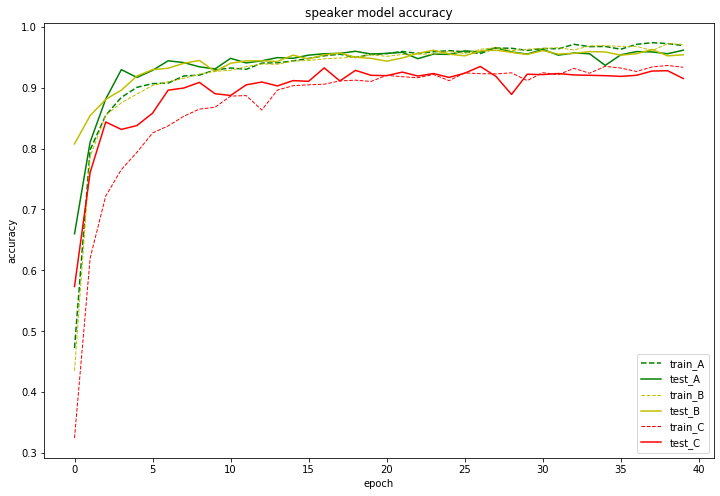

In [56]:
plt.figure(figsize = (12, 8))
plt.plot(history_A.history['acc'], 'g--', linewidth=1)
plt.plot(history_A.history['val_acc'], 'g')
plt.plot(history_B.history['acc'], 'y--', linewidth=1)
plt.plot(history_B.history['val_acc'], 'y')
plt.plot(history_C.history['acc'], 'r--', linewidth=1)
plt.plot(history_C.history['val_acc'], 'r')
plt.title('speaker model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_A', 'test_A', 'train_B', 'test_B', 'train_C', 'test_C'], loc='lower right')
plt.show()

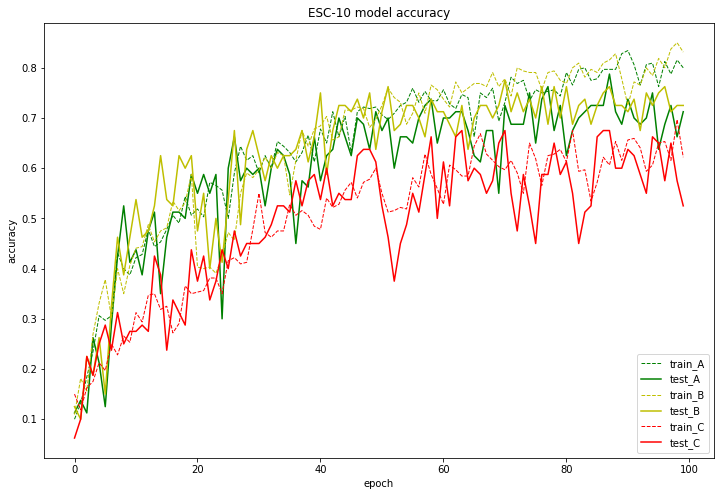

In [57]:
plt.figure(figsize = (12, 8))
plt.plot(history_ESC_A.history['acc'], 'g--', linewidth=1)
plt.plot(history_ESC_A.history['val_acc'], 'g')
plt.plot(history_ESC_B.history['acc'], 'y--', linewidth=1)
plt.plot(history_ESC_B.history['val_acc'], 'y')
plt.plot(history_ESC_C.history['acc'], 'r--', linewidth=1)
plt.plot(history_ESC_C.history['val_acc'], 'r')
plt.title('ESC-10 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_A', 'test_A', 'train_B', 'test_B', 'train_C', 'test_C'], loc='lower right')
plt.show()